In [1]:
from pathlib import Path
from os.path import join
import pandas as pd
import numpy as np
from numpy.random import choice, randint, uniform, randn
import seaborn as sns
import matplotlib.pyplot as plt
import ipyvolume as ipv
from sklearn.datasets import fetch_mldata, make_swiss_roll, make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import colorlover as cl

In [2]:
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format

In [20]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    returns = (store['quandl/wiki/prices']
               .loc[idx['2000':'2018', :], 'adj_close']
               .unstack('ticker')
               .resample('W')
               .last()
               .pct_change())

In [21]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 938 entries, 2000-01-16 to 2018-03-11
Columns: 1583 entries, A to ZIXI
dtypes: float64(1583)
memory usage: 11.3 MB


In [22]:
returns = returns.sample(n=250)
daily_avg = returns.mean(1)
returns = returns.apply(lambda x: x.fillna(daily_avg))

In [23]:
pca = PCA(n_components=2)

### T-Stochastic Neighbor Embedding (TSNE): Parameter Settings

#### Perplexity: emphasis on local vs global structure

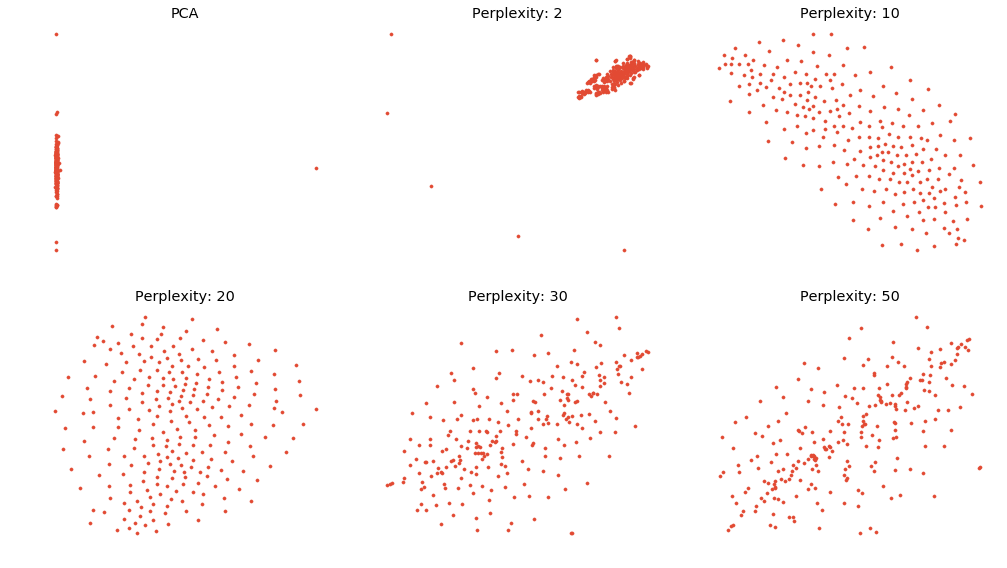

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
axes = axes.flatten()

axes[0].scatter(*pca.fit_transform(returns).T, s=10)
axes[0].set_title('PCA')
axes[0].axis('off')

for i, p in enumerate([2,10, 20, 30, 50], 1):
    embedding = TSNE(perplexity=p, n_iter=5000).fit_transform(returns)
    axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10)
    axes[i].set_title('Perplexity: {:.0f}'.format(p))
    axes[i].axis('off')
fig.tight_layout()
fig.savefig('perplexity', dpi=300);

#### Convergence with `n_iter`

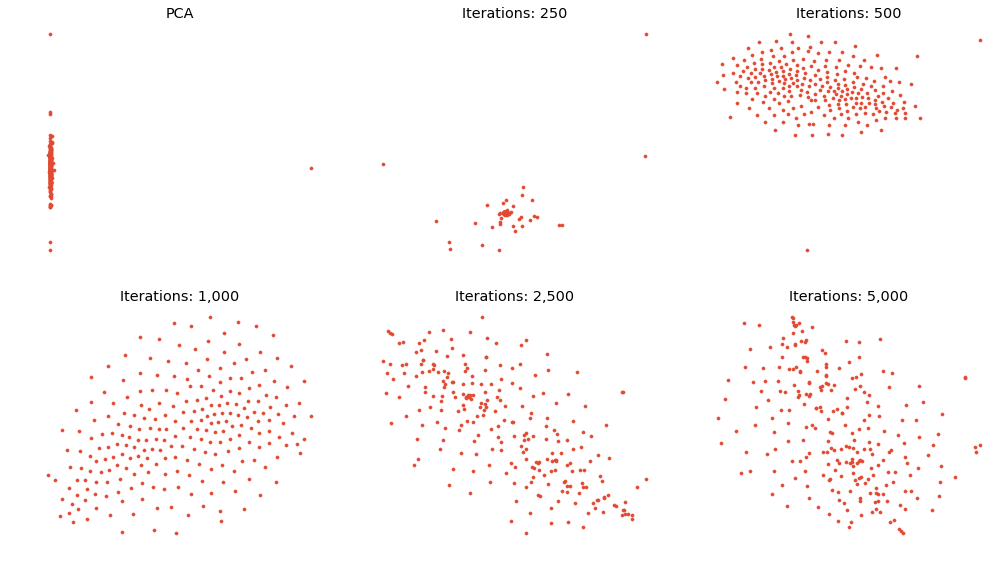

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()
axes[0].scatter(*pca.fit_transform(returns).T, s=10)
axes[0].set_title('PCA')
axes[0].axis('off')

for i, n in enumerate([250, 500, 1000, 2500, 5000], 1):
    embedding=TSNE(perplexity=30, n_iter=n).fit_transform(returns)
    axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10)
    axes[i].set_title('Iterations: {:,.0f}'.format(n))
    axes[i].axis('off')
fig.tight_layout()
fig.savefig('iterations', dpi=300);

### Uniform Manifold Approximation and Projection (UMAP): Parameter Settings

#### # Neighbors

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



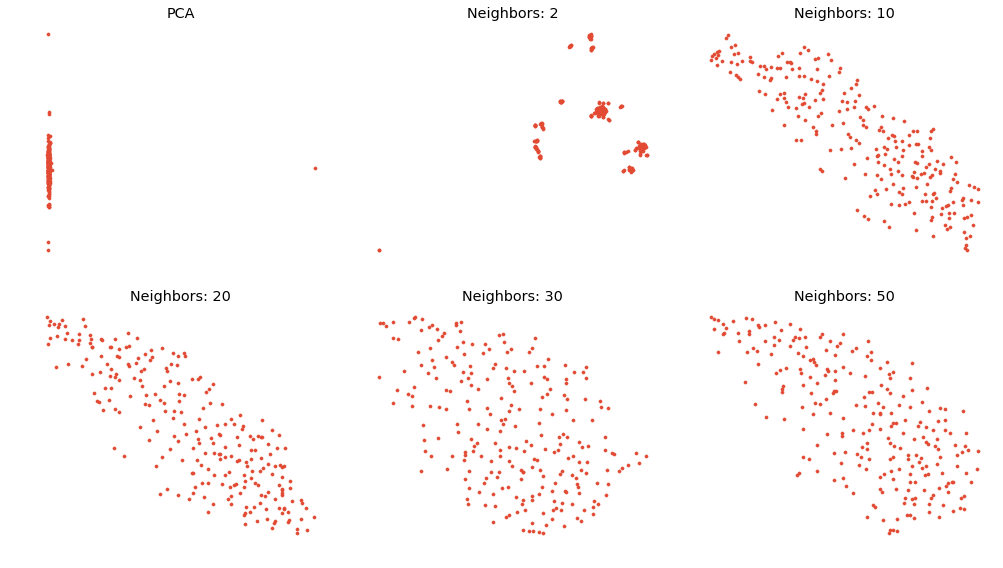

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
axes = axes.flatten()

axes[0].scatter(*pca.fit_transform(returns).T, s=10)
axes[0].set_title('PCA')
axes[0].axis('off')
for i, n in enumerate([2,10, 20, 30, 50], 1):
    embedding = umap.UMAP(n_neighbors=n, min_dist=0.1).fit_transform(returns)    
    axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10)
    axes[i].set_title('Neighbors: {:.0f}'.format(n))
    axes[i].axis('off')
fig.tight_layout()
fig.savefig('umap_n_neighbors', dpi=300);             

 #### Minimum Distance

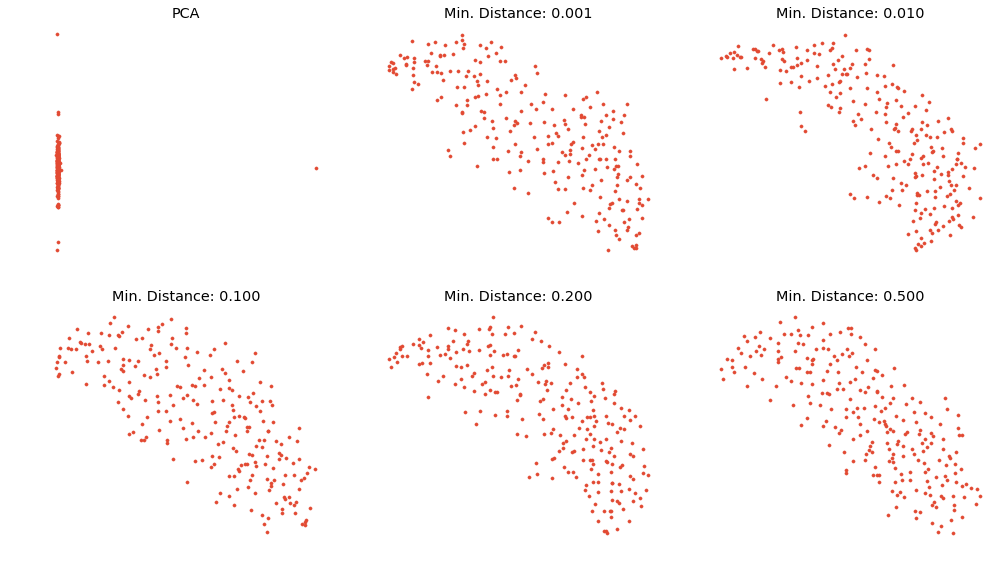

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
axes = axes.flatten()

axes[0].scatter(*pca.fit_transform(returns).T, s=10)
axes[0].set_title('PCA')
axes[0].axis('off')

for i, d in enumerate([.001, .01, .1, .2, .5], 1):
    embedding = umap.UMAP(n_neighbors=30, min_dist=d).fit_transform(returns)
    axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10)
    axes[i].set_title('Min. Distance: {:.3f}'.format(d))
    axes[i].axis('off')
fig.tight_layout()
fig.savefig('umap_distance', dpi=300);

### Non-Linear Manifolds: Swiss Roll

In [ ]:
n_samples = 10000
palette = sns.color_palette('viridis', n_colors=n_samples)

In [ ]:
zeros = np.zeros(n_samples) + .5
swiss_3d, swiss_val = make_swiss_roll(
    n_samples=n_samples, noise=.1, random_state=42)

swiss_3d = swiss_3d[swiss_val.argsort()[::-1]]
x, y, z = swiss_3d.T 

### TSNE

Using pre-computed T-SNE and UMAP results due to the long running times, esp. for T-SNE.

In [ ]:
# pre-computed manifold results for the various datasets and algorithms, as well as parameter settings:
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    print(store.info())

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 28))
method = 'tsne'
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    labels = store['/'.join(['swiss', 'label'])]
    for row, perplexity in enumerate([2, 5, 10, 20 , 30, 50, 100]):
        for col, n_iter in enumerate([250, 500, 1000, 3000, 5000]):
            x, y = store.get('/'.join(['swiss',  method, str(perplexity), str(n_iter)])).T.values
            axes[row, col].scatter(x, y, c=palette, s=5)
            axes[row, col].set_title('Perplexity: {} | Iterations: {}'.format(perplexity, n_iter))
            axes[row, col].axis('off')
fig.tight_layout()
fig.suptitle('T-Stochastic Neighbor Embedding (TSNE)')
fig.subplots_adjust(top=.94)

### UMAP

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 20))
method = 'umap'
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    labels = store['swiss/label']
    for row, n_neighbors in enumerate([2, 5, 10, 25, 50]):
        for col, min_distance in enumerate([1, 10, 20, 50]):
            x, y = store.get('swiss/' + method + '/' + str(n_neighbors) + '/' + str(min_distance)).T.values
            axes[row, col].scatter(x, y, c=palette, s=5)
            axes[row, col].set_title('Neighbors: {} | Min. Distance {:.2f}'.format(n_neighbors, min_distance/100))
            axes[row, col].axis('off')
fig.tight_layout()
fig.suptitle('Uniform Manifold Approximation and Projection (UMAP)')
fig.subplots_adjust(top=.94)

### Handwritten Digits

In [ ]:
mnist = fetch_mldata('MNIST original', data_home='.')
classes = sorted(np.unique(mnist.target).astype(int))
mnist.data.shape

In [ ]:
ipv_cmap = sns.color_palette("Paired", n_colors=10)
print(classes)
sns.palplot(ipv_cmap)

#### Plot sample images

In [ ]:
image_size = int(np.sqrt(mnist.data.shape[1])) # 28 x 28 pixels
n_samples = 15

In [ ]:
fig, ax = plt.subplots()
mnist_sample = np.empty(
    shape=(image_size * len(classes), image_size * n_samples))
for row, label in enumerate(classes):
    label_data = np.squeeze(np.argwhere(mnist.target == label))
    samples = choice(label_data, size=n_samples, replace=False)
    i = row * image_size
    for col, sample in enumerate(samples):
        j = col * image_size
        mnist_sample[i:i+image_size, j:j +
                     image_size] = mnist.data[sample].reshape(image_size, -1)

ax.imshow(mnist_sample, cmap='Blues')
plt.title('Handwritten Digits')
plt.axis('off')
plt.tight_layout()

In [ ]:
plotly_cmap = cl.to_rgb( cl.scales['10']['qual']['Paired'])
def plotly_scatter(data, label, title, color, x='x', y='y'):
    fig = dict(
        data=[
            dict(
                type='scattergl',
                x=data[:, 0],
                y=data[:, 1],
                legendgroup="group",
                text=label.astype(int),
                mode='markers',
                marker=Marker(
                    size=5,
                    color=color,
                    autocolorscale=False,
                    showscale=False,
                    opacity=.9,
                    colorbar=ColorBar(
                        title='Class'
                    ),
                    line=dict(width=1))),
        ],
        layout=dict(title=title,
                    width=1200,
                    font=dict(color='white'),
                    xaxis=dict(
                        title=x, 
                        hoverformat='.1f', 
                        showgrid=False),
                    yaxis=dict(title=y, 
                               hoverformat='.1f', 
                               showgrid=False),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)'
                    ))

    iplot(fig, show_link=False)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
methods = ['tsne', 'umap']
params = {}
params['tsne'] = [5, 10, 20, 35]
params['umap'] = [5, 15, 25, 35]
param_labels = {'tsne': 'Perplexity', 'umap': 'Neighbors'}
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    labels = store['mnist/labels']
    color = [sns.color_palette('Paired', 10)[int(i)] for i in labels]
    for row, method in enumerate(methods):
        for col, param in enumerate(params[method]):
            x, y = store.get('mnist/' + method + '/2/' + str(param)).T.values
            axes[row, col].scatter(x, y, c=color, s=5)
            axes[row, col].set_title('{} | {}: {}'.format(method.upper(), param_labels[method], param))
            axes[row, col].axis('off')
fig.tight_layout();

In [ ]:
def get_result(source, method, params):
    key = '/'.join([source, method, '/'.join([str(p) for p in params])])
    with pd.HDFStore(join('data', 'manifolds.h5')) as store:
        data = store[key].values
        labels = store['/'.join([source, 'labels'])]
    return data, labels

### Load Fashion MNIST Data

In [ ]:
fashion_mnist = pd.read_csv(Path('data') / 'fashion-mnist_train.csv.gz')
fashion_label = fashion_mnist.label
fashion_data = fashion_mnist.drop('label', axis=1).values
classes = sorted(np.unique(fashion_label).astype(int))

In [ ]:
image_size = int(np.sqrt(fashion_data.shape[1])) # 28 x 28 pixels
n_samples = 15

In [ ]:
fig, ax = plt.subplots()
fashion_sample = np.empty(shape=(image_size * len(classes),
                               image_size * n_samples))
for row, label in enumerate(classes):
    label_data = np.squeeze(np.argwhere(fashion_label == label))
    samples = choice(label_data, size=n_samples, replace=False)
    i = row * image_size
    for col, sample in enumerate(samples):  
        j = col * image_size
        fashion_sample[i:i+image_size,
                     j:j + image_size] = fashion_data[sample].reshape(image_size, -1)

ax.imshow(fashion_sample, cmap='Blues')
plt.title('Fashion Images')
plt.axis('off')
plt.tight_layout();

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
source = 'fashion'
methods = ['tsne', 'umap']
params = {}
params['tsne'] = [10, 20, 30, 50]
params['umap'] = [5, 15, 25, 35]
param_labels = {'tsne': 'Perplexity', 'umap': 'Neighbors'}
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    labels = store[source + '/labels']
    color = [sns.color_palette('Paired', 10)[int(i)] for i in labels]
    for row, method in enumerate(methods):
        for col, param in enumerate(params[method]):
            x, y = store.get(source + '/' + method + '/2/' + str(param)).T.values
            axes[row, col].scatter(x, y, c=color, s=5)
            axes[row, col].set_title('{} | {}: {}'.format(method.upper(), param_labels[method], param))
            axes[row, col].axis('off')
fig.tight_layout();

In [ ]:
data, labels = get_result('fashion', 'tsne', [2, 25])
plotly_color = [plotly_cmap[int(i)] for i in labels]
plotly_scatter(data=data, 
               title='MNIST TSNE Projection',
               label=labels,
               color=plotly_color)

In [ ]:
data, labels = get_result('fashion', 'umap', [2, 15])
plotly_color = [plotly_cmap[int(i)] for i in labels]
plotly_scatter(data=data, 
               title='MNIST UMAP Projection',
               label=labels,
               color=plotly_color)

In [ ]:
data, labels = get_result('fashion', 'tsne', [3, 25])
ipv_color = [ipv_cmap[int(t)] for t in labels]
ipv.quickscatter(*data.T, size=.5, color=ipv_color, marker='sphere')